In [6]:

# all config/downloads to use fastai
# !pip install pandas --upgrade
#!pip install plotly --upgrade
#!pip install fastai==0.7.0
#!pip install torchtext==0.2.3
!pip install torch
#!pip install torchvision
#!pip install Pillow>=4.1.1
#!pip install image
#!pip install matplotlib

In [7]:
from google.colab import drive
drive.mount('/mnt')

Drive already mounted at /mnt; to attempt to forcibly remount, call drive.mount("/mnt", force_remount=True).


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [9]:
data_pd = pd.read_csv("/mnt/MyDrive/datasets/ratings.csv")
movies_pd = pd.read_csv('/mnt/MyDrive/datasets/movies.csv')
data_pd = data_pd.sample(frac=1)

In [10]:
data_pd.head()

,userId,movieId,rating,timestamp
6363,43,317,4.0,848993903
9973,65,97752,4.0,1494767354
98862,608,1200,4.5,1117491293
89632,580,6645,4.0,1167861051
3589,21,110102,3.5,1407619805


In [11]:
movies_pd.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
u_temp = list(data_pd.userId.unique())
u_temp.sort()

m_temp = list(data_pd.movieId.unique())
m_temp.sort()

In [13]:
movie_dict = dict(list(zip(m_temp,range(len(m_temp)))))
user_dict = dict(list(zip(u_temp,range(len(u_temp)))))

In [14]:
data_pd['userId'] = data_pd['userId'].map(lambda x: user_dict[x])
data_pd['movieId'] = data_pd['movieId'].map(lambda x: movie_dict[x])

In [15]:
X = data_pd[['userId','movieId']].values
y = data_pd[['rating']].values

In [16]:
y = y.astype(np.float)

In [17]:
type(np.double(1.))

numpy.float64

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
class RatingDataset():
  def __init__(self, train, label):
    self.feature_= train
    self.label_= label
  def __len__(self):
    #return size of dataset
    return len(self.feature_)
  def __getitem__(self, idx):
    return torch.tensor(self.feature_[idx]),torch.tensor(self.label_[idx])

In [20]:
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

In [21]:
bs = 1000
train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)

In [22]:
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items,1)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)
        
    def forward(self, user, item):
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        #pred = pred.float()
        return pred.squeeze()

In [23]:
n,m =  len(data_pd.userId.unique()), len(data_pd.movieId.unique())

In [24]:
nfactor = 100
model = MatrixFactorization(n, m, n_factors=nfactor)

In [25]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# dev = torch.device("cpu")

In [26]:
model.parameters

<bound method Module.parameters of MatrixFactorization(
  (user_factors): Embedding(610, 100)
  (item_factors): Embedding(9724, 100)
  (user_biases): Embedding(610, 1)
  (item_biases): Embedding(9724, 1)
)>

In [27]:
dev

device(type='cuda')

In [28]:
loss_func = torch.nn.MSELoss()
model.to(dev)

MatrixFactorization(
  (user_factors): Embedding(610, 100)
  (item_factors): Embedding(9724, 100)
  (user_biases): Embedding(610, 1)
  (item_biases): Embedding(9724, 1)
)

In [29]:
model.parameters
model.double()

MatrixFactorization(
  (user_factors): Embedding(610, 100)
  (item_factors): Embedding(9724, 100)
  (user_biases): Embedding(610, 1)
  (item_biases): Embedding(9724, 1)
)

In [30]:
train_losses = []
test_losses = []
epoches_list = []

epoches = 1000
val_loss = 0
count_epoch = 0
last_loss = 0
min_delta = 0.005
min_val_loss = 1.5
min_loss = 1.2
n_epochs_stop = 20
for epoch in range(0,epoches):
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))  # progress bar
    count = 0
    cum_loss = 0.
    for i,( train_batch, label_batch) in pbar:
        count = 1 + i
        # Predict and calculate loss for user factor and bias
        optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
        prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
        
        loss = loss_func(prediction, label_batch.to(dev))    
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        optimizer.zero_grad()
        
        #predict and calculate loss for item factor and bias
        optimizer = torch.optim.SGD([model.item_biases.weight,model.item_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
        prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
        loss = loss_func(prediction, label_batch.to(dev))
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        optimizer.zero_grad()
        
        cum_loss += loss.item()
        pbar.set_description('training loss at {} batch {}: {}'.format(epoch,i,loss.item()))
    train_loss = cum_loss/count
    val_loss += loss
    val_loss = val_loss / len(train_dataloader)

    delta = train_loss - last_loss
    if abs(delta) < abs(min_delta):
      count_epoch += 1
    if count_epoch == n_epochs_stop:
      print('\n EARLY STOP!')
      break
    if delta > min_delta:
      count_epoch = 0

    last_loss = train_loss
    pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))  # progress bar
    cum_loss =0.
    count = 0
    for i,( test_batch, label_batch) in pbar:
        count = 1 + i
        with torch.no_grad():
            prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            cum_loss += loss.item()
            pbar.set_description('test loss at {} batch {}: {}'.format(epoch,i,loss.item()))
    test_loss = cum_loss/count

    test_losses.append(test_loss)
    train_losses.append(train_loss)
    epoches_list.append(epoch)
    print('avg training loss: ', train_loss, ' avg test loss: ',test_loss)

  0%|          | 0/81 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
training loss at 0 batch 79: 12.747178107011447:  96%|█████████▋| 78/81 [00:02<00:00, 29.59it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([668, 1])) that is different to the input size (torch.Size([668])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
test loss at 0 batch 19: 12.877890422621174:  86%|████████▌ | 18/21 [00:00<00:00, 32.39it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning

avg training loss:  13.079297643005635  avg test loss:  12.90033095962017


training loss at 2 batch 4: 12.373283688401477:   4%|▎         | 3/81 [00:00<00:02, 29.00it/s]

avg training loss:  12.596933837460726  avg test loss:  12.439928133458213


training loss at 3 batch 4: 11.856462064422795:   4%|▎         | 3/81 [00:00<00:02, 29.90it/s]

avg training loss:  12.148801040964512  avg test loss:  12.013853231663505


training loss at 4 batch 4: 11.636600531316939:   5%|▍         | 4/81 [00:00<00:02, 32.18it/s]

avg training loss:  11.734292886556489  avg test loss:  11.617807406918754


training loss at 5 batch 4: 11.095034708200991:   4%|▎         | 3/81 [00:00<00:02, 29.70it/s]

avg training loss:  11.350442536674976  avg test loss:  11.248851023247052


training loss at 6 batch 5: 10.98040684316396:   5%|▍         | 4/81 [00:00<00:02, 30.87it/s] 

avg training loss:  10.990831058143264  avg test loss:  10.904391224444904


training loss at 7 batch 3: 10.329965870389152:   4%|▎         | 3/81 [00:00<00:03, 22.00it/s]

avg training loss:  10.655556676146318  avg test loss:  10.581958448404315


training loss at 8 batch 4: 9.900027936279942:   5%|▍         | 4/81 [00:00<00:02, 31.71it/s]

avg training loss:  10.340859868347176  avg test loss:  10.279532263709502


training loss at 9 batch 4: 9.62914263358171:   5%|▍         | 4/81 [00:00<00:02, 31.33it/s] 

avg training loss:  10.044778550753474  avg test loss:  9.995200154222928


training loss at 10 batch 2: 9.229407387864345:   2%|▏         | 2/81 [00:00<00:04, 17.00it/s]

avg training loss:  9.770116150318898  avg test loss:  9.72728294019133


training loss at 11 batch 4: 9.676826644111793:   4%|▎         | 3/81 [00:00<00:03, 25.95it/s]

avg training loss:  9.50690892694942  avg test loss:  9.47442112679028


training loss at 12 batch 4: 8.944707610261851:   4%|▎         | 3/81 [00:00<00:02, 29.58it/s]

avg training loss:  9.260776114474707  avg test loss:  9.23533443671242


training loss at 13 batch 4: 8.797533766482966:   4%|▎         | 3/81 [00:00<00:03, 24.23it/s]

avg training loss:  9.027205894817401  avg test loss:  9.008838658524997


training loss at 14 batch 2: 8.56305864847163:   4%|▎         | 3/81 [00:00<00:03, 20.14it/s]

avg training loss:  8.808238679073801  avg test loss:  8.793920714721104


training loss at 15 batch 2: 8.442975874870069:   2%|▏         | 2/81 [00:00<00:04, 17.16it/s]

avg training loss:  8.59644476485069  avg test loss:  8.589708203238317


training loss at 16 batch 4: 8.470035283015564:   4%|▎         | 3/81 [00:00<00:02, 29.77it/s]

avg training loss:  8.397632564525486  avg test loss:  8.395388989800301


training loss at 17 batch 4: 8.390809640579727:   5%|▍         | 4/81 [00:00<00:02, 31.74it/s]

avg training loss:  8.205105966609365  avg test loss:  8.2102064154669


training loss at 18 batch 4: 8.070239806636202:   4%|▎         | 3/81 [00:00<00:02, 29.02it/s]

avg training loss:  8.024463195853814  avg test loss:  8.033497780412437


training loss at 19 batch 4: 7.762801556826159:   5%|▍         | 4/81 [00:00<00:02, 31.09it/s]

avg training loss:  7.853516771957757  avg test loss:  7.864727218806808


training loss at 20 batch 3: 7.397877180607968:   4%|▎         | 3/81 [00:00<00:02, 26.71it/s]

avg training loss:  7.6875043171304664  avg test loss:  7.703230183020798


test loss at 20 batch 20: 7.454955157832518: 100%|██████████| 21/21 [00:00<00:00, 37.09it/s]
training loss at 21 batch 4: 7.4395021249877065:   4%|▎         | 3/81 [00:00<00:02, 29.83it/s]

avg training loss:  7.53000123994622  avg test loss:  7.54871773545115


training loss at 22 batch 4: 7.300696920011557:   5%|▍         | 4/81 [00:00<00:02, 30.48it/s]

avg training loss:  7.375798716726935  avg test loss:  7.400575758586908


training loss at 23 batch 4: 7.073113266458695:   4%|▎         | 3/81 [00:00<00:02, 28.74it/s]

avg training loss:  7.233407475848497  avg test loss:  7.25847156378545


training loss at 24 batch 4: 6.773389498314699:   4%|▎         | 3/81 [00:00<00:02, 28.23it/s] 

avg training loss:  7.095367179469591  avg test loss:  7.122051648098505


test loss at 24 batch 20: 6.892400146696212: 100%|██████████| 21/21 [00:00<00:00, 25.63it/s]
training loss at 25 batch 3: 6.7779321794710965:   4%|▎         | 3/81 [00:00<00:03, 22.76it/s]

avg training loss:  6.959970145921457  avg test loss:  6.9909317591857905


training loss at 26 batch 2: 6.859676132953041:   2%|▏         | 2/81 [00:00<00:04, 18.87it/s]

avg training loss:  6.833086594985946  avg test loss:  6.864837655082953


training loss at 27 batch 4: 7.009708135172739:   4%|▎         | 3/81 [00:00<00:02, 29.62it/s]

avg training loss:  6.7090075345001825  avg test loss:  6.743451185199588


training loss at 28 batch 4: 6.635750439008585:   5%|▍         | 4/81 [00:00<00:02, 31.34it/s]

avg training loss:  6.5891184643493865  avg test loss:  6.626540653876016


training loss at 29 batch 4: 6.308886804888749:   4%|▎         | 3/81 [00:00<00:02, 27.52it/s] 

avg training loss:  6.475909932191453  avg test loss:  6.513881233930791


training loss at 30 batch 4: 6.280564069413492:   5%|▍         | 4/81 [00:00<00:02, 29.84it/s]

avg training loss:  6.364172919075976  avg test loss:  6.405177686830678


training loss at 31 batch 2: 6.542085293010835:   4%|▎         | 3/81 [00:00<00:03, 20.92it/s]

avg training loss:  6.258181712038169  avg test loss:  6.300302281063438


training loss at 32 batch 4: 5.730662693047968:   4%|▎         | 3/81 [00:00<00:02, 29.79it/s]

avg training loss:  6.155680080193656  avg test loss:  6.199027483671239


training loss at 33 batch 4: 6.124382037005836:   5%|▍         | 4/81 [00:00<00:02, 31.41it/s]

avg training loss:  6.057313088580225  avg test loss:  6.101167138219898


test loss at 33 batch 20: 5.896835101602151: 100%|██████████| 21/21 [00:00<00:00, 25.45it/s]
training loss at 34 batch 3: 5.9727958443407445:   4%|▎         | 3/81 [00:00<00:03, 21.23it/s]

avg training loss:  5.962526565450132  avg test loss:  6.00655683452135


test loss at 34 batch 20: 5.804277460078605: 100%|██████████| 21/21 [00:00<00:00, 31.97it/s]
training loss at 35 batch 2: 5.8548960660671945:   2%|▏         | 2/81 [00:00<00:04, 17.88it/s]

avg training loss:  5.870230771015282  avg test loss:  5.915075218995261


training loss at 36 batch 5: 5.670348744416474:   4%|▎         | 3/81 [00:00<00:02, 29.44it/s]

avg training loss:  5.779348272735504  avg test loss:  5.826499107485154


training loss at 37 batch 3: 5.444130158778495:   2%|▏         | 2/81 [00:00<00:04, 18.21it/s]

avg training loss:  5.6925445246227095  avg test loss:  5.740754911013331


training loss at 38 batch 2: 5.43332552102309:   2%|▏         | 2/81 [00:00<00:04, 19.59it/s] 

avg training loss:  5.609820734448097  avg test loss:  5.657696784933236


training loss at 39 batch 3: 5.596433855680313:   4%|▎         | 3/81 [00:00<00:02, 26.91it/s]

avg training loss:  5.528913924258964  avg test loss:  5.577234459220501


training loss at 40 batch 4: 5.345315213697779:   5%|▍         | 4/81 [00:00<00:02, 30.85it/s]

avg training loss:  5.448085042902004  avg test loss:  5.499184721960144


training loss at 41 batch 4: 5.287752641523453:   4%|▎         | 3/81 [00:00<00:02, 28.93it/s]

avg training loss:  5.373692090960271  avg test loss:  5.423512814523639


training loss at 42 batch 2: 5.433170206783383:   2%|▏         | 2/81 [00:00<00:04, 18.82it/s]

avg training loss:  5.297895298805485  avg test loss:  5.3500655000538035


training loss at 43 batch 4: 5.183465005106018:   4%|▎         | 3/81 [00:00<00:02, 28.02it/s] 

avg training loss:  5.225147987643866  avg test loss:  5.278802649584651


training loss at 44 batch 4: 5.084755240648146:   4%|▎         | 3/81 [00:00<00:02, 27.45it/s]

avg training loss:  5.158128624727961  avg test loss:  5.209596341581207


training loss at 45 batch 3: 5.083935209532162:   4%|▎         | 3/81 [00:00<00:02, 26.64it/s]

avg training loss:  5.08874706883819  avg test loss:  5.14235297171215


training loss at 46 batch 4: 4.740958022310887:   4%|▎         | 3/81 [00:00<00:02, 26.56it/s]

avg training loss:  5.022178362200902  avg test loss:  5.077047493720876


training loss at 47 batch 4: 4.999056063680928:   5%|▍         | 4/81 [00:00<00:02, 30.56it/s]

avg training loss:  4.959530629249224  avg test loss:  5.013557308714687


training loss at 48 batch 3: 5.040984493726492:   2%|▏         | 2/81 [00:00<00:04, 18.22it/s]

avg training loss:  4.896037340487131  avg test loss:  4.951822225387587


training loss at 49 batch 4: 4.685235319295831:   4%|▎         | 3/81 [00:00<00:02, 27.54it/s]

avg training loss:  4.837940342418676  avg test loss:  4.89177415637723


training loss at 50 batch 2: 5.154904197726273:   2%|▏         | 2/81 [00:00<00:04, 18.35it/s]

avg training loss:  4.779127943845949  avg test loss:  4.833344241388407


training loss at 51 batch 4: 4.724114927035624:   4%|▎         | 3/81 [00:00<00:02, 27.96it/s]

avg training loss:  4.719559607826871  avg test loss:  4.776460806722164


training loss at 52 batch 4: 4.685418292755724:   4%|▎         | 3/81 [00:00<00:02, 28.90it/s]

avg training loss:  4.6655011453370365  avg test loss:  4.721102922976192


training loss at 53 batch 3: 4.536511295995366:   4%|▎         | 3/81 [00:00<00:03, 24.39it/s]

avg training loss:  4.609782623522474  avg test loss:  4.667179717278138


training loss at 54 batch 4: 4.580434642509799:   4%|▎         | 3/81 [00:00<00:02, 28.81it/s]

avg training loss:  4.558448902085976  avg test loss:  4.61467287168554


test loss at 54 batch 20: 4.437203868437031: 100%|██████████| 21/21 [00:00<00:00, 34.29it/s]
training loss at 55 batch 4: 4.3923296351048915:   4%|▎         | 3/81 [00:00<00:02, 28.10it/s]

avg training loss:  4.507179290456236  avg test loss:  4.563469425114967


training loss at 56 batch 4: 4.36891162935879:   4%|▎         | 3/81 [00:00<00:02, 28.68it/s] 

avg training loss:  4.456438786639639  avg test loss:  4.513588614195964


training loss at 57 batch 2: 4.636757814681586:   2%|▏         | 2/81 [00:00<00:04, 19.73it/s]

avg training loss:  4.4085002439877865  avg test loss:  4.464954564595102


training loss at 58 batch 3: 4.370201963063705:   2%|▏         | 2/81 [00:00<00:03, 19.99it/s]

avg training loss:  4.35944741216165  avg test loss:  4.4175305104991525


training loss at 59 batch 3: 4.631315764741404:   2%|▏         | 2/81 [00:00<00:04, 19.19it/s]

avg training loss:  4.314500621017114  avg test loss:  4.371288851646197


training loss at 60 batch 4: 4.157369015351503:   4%|▎         | 3/81 [00:00<00:02, 29.62it/s]

avg training loss:  4.269943480514363  avg test loss:  4.326151096209325


training loss at 61 batch 3: 4.337700000344775:   2%|▏         | 2/81 [00:00<00:04, 19.64it/s]

avg training loss:  4.22541159492429  avg test loss:  4.282103786111729


training loss at 62 batch 4: 4.082970131406616:   4%|▎         | 3/81 [00:00<00:02, 27.08it/s]

avg training loss:  4.181255868086466  avg test loss:  4.239101798547873


test loss at 62 batch 20: 4.067192468395724: 100%|██████████| 21/21 [00:00<00:00, 25.24it/s]
training loss at 63 batch 3: 3.9119755081943803:   4%|▎         | 3/81 [00:00<00:03, 22.27it/s]

avg training loss:  4.139789582540976  avg test loss:  4.197108148326668


training loss at 64 batch 3: 3.908622834974028:   4%|▎         | 3/81 [00:00<00:03, 21.84it/s]

avg training loss:  4.100201561525966  avg test loss:  4.156109557605942


test loss at 64 batch 20: 3.9853606902565604: 100%|██████████| 21/21 [00:00<00:00, 32.87it/s]
training loss at 65 batch 3: 3.9834218466035596:   2%|▏         | 2/81 [00:00<00:03, 19.91it/s]

avg training loss:  4.057692926186795  avg test loss:  4.116057475432685


training loss at 66 batch 4: 3.843343110669242:   4%|▎         | 3/81 [00:00<00:02, 28.88it/s]

avg training loss:  4.018300480884164  avg test loss:  4.076943272145444


training loss at 67 batch 4: 3.860066532835177:   4%|▎         | 3/81 [00:00<00:02, 29.53it/s] 

avg training loss:  3.9818066910826393  avg test loss:  4.038718208857977


test loss at 67 batch 20: 3.869486391527756: 100%|██████████| 21/21 [00:00<00:00, 32.26it/s]
training loss at 68 batch 3: 3.8234496238674494:   2%|▏         | 2/81 [00:00<00:04, 18.28it/s]

avg training loss:  3.9437674279732953  avg test loss:  4.001342696046474


test loss at 68 batch 20: 3.83260903750751: 100%|██████████| 21/21 [00:00<00:00, 26.64it/s]
training loss at 69 batch 2: 3.8630934922085336:   2%|▏         | 2/81 [00:00<00:04, 19.11it/s]

avg training loss:  3.906913798763936  avg test loss:  3.964813283371246


training loss at 70 batch 4: 3.630994604906184:   5%|▍         | 4/81 [00:00<00:02, 28.78it/s]

avg training loss:  3.8715635775357997  avg test loss:  3.929097640371999


test loss at 70 batch 20: 3.7612569654380974: 100%|██████████| 21/21 [00:00<00:00, 31.63it/s]
training loss at 71 batch 2: 3.6467084371100498:   2%|▏         | 2/81 [00:00<00:04, 17.80it/s]

avg training loss:  3.8368441502812733  avg test loss:  3.894150160803009


test loss at 71 batch 20: 3.7267592806510006: 100%|██████████| 21/21 [00:00<00:00, 33.40it/s]
training loss at 72 batch 3: 3.7323639861050686:   4%|▎         | 3/81 [00:00<00:03, 23.56it/s]

avg training loss:  3.802950449730607  avg test loss:  3.8599851514434573


test loss at 72 batch 20: 3.692969751045666: 100%|██████████| 21/21 [00:00<00:00, 26.05it/s]
training loss at 73 batch 4: 3.6359051610107342:   4%|▎         | 3/81 [00:00<00:03, 25.78it/s]

avg training loss:  3.768391217785616  avg test loss:  3.8265442018118345


training loss at 74 batch 4: 3.730371056301342:   4%|▎         | 3/81 [00:00<00:02, 26.67it/s] 

avg training loss:  3.7364337948912345  avg test loss:  3.793834530407718


test loss at 74 batch 20: 3.627643793173351: 100%|██████████| 21/21 [00:00<00:00, 31.83it/s]
training loss at 75 batch 4: 3.6072824586922874:   4%|▎         | 3/81 [00:00<00:03, 25.35it/s]

avg training loss:  3.704663971514485  avg test loss:  3.7618161140739765


training loss at 76 batch 4: 3.359946646859099:   4%|▎         | 3/81 [00:00<00:02, 28.79it/s]

avg training loss:  3.6737186105957647  avg test loss:  3.7304657950480213


test loss at 76 batch 20: 3.5649929737564015: 100%|██████████| 21/21 [00:00<00:00, 30.93it/s]
training loss at 77 batch 3: 3.6493163631779164:   2%|▏         | 2/81 [00:00<00:04, 19.49it/s]

avg training loss:  3.6427613144492232  avg test loss:  3.6997806453512383


training loss at 78 batch 4: 3.60604162347711:   4%|▎         | 3/81 [00:00<00:03, 25.60it/s] 

avg training loss:  3.612013606584216  avg test loss:  3.6697289233610895


test loss at 78 batch 20: 3.504899737040103: 100%|██████████| 21/21 [00:00<00:00, 24.42it/s]
training loss at 79 batch 2: 3.6186511770443244:   4%|▎         | 3/81 [00:00<00:03, 20.66it/s]

avg training loss:  3.5835290918327645  avg test loss:  3.6402930931982524


test loss at 79 batch 20: 3.4757864357120405: 100%|██████████| 21/21 [00:00<00:00, 31.48it/s]
training loss at 80 batch 4: 3.6271641480044994:   4%|▎         | 3/81 [00:00<00:02, 26.38it/s]

avg training loss:  3.554592571822816  avg test loss:  3.611460336248119


training loss at 81 batch 4: 3.614393947360879:   4%|▎         | 3/81 [00:00<00:02, 28.13it/s]

avg training loss:  3.5281690430914914  avg test loss:  3.5832092938947064


training loss at 82 batch 4: 3.401489472972193:   4%|▎         | 3/81 [00:00<00:02, 27.17it/s]

avg training loss:  3.499534364468149  avg test loss:  3.555520029312118


training loss at 83 batch 3: 3.348600958224318:   4%|▎         | 3/81 [00:00<00:03, 23.70it/s] 

avg training loss:  3.4729607088895253  avg test loss:  3.528385744912318


test loss at 83 batch 20: 3.36507708967607: 100%|██████████| 21/21 [00:00<00:00, 25.04it/s]
training loss at 84 batch 3: 3.7003934152615643:   4%|▎         | 3/81 [00:00<00:02, 27.39it/s]

avg training loss:  3.444762160481014  avg test loss:  3.501789312316773


test loss at 84 batch 20: 3.338773259878463: 100%|██████████| 21/21 [00:00<00:00, 34.80it/s]
training loss at 85 batch 4: 3.3705353368434303:   4%|▎         | 3/81 [00:00<00:02, 27.42it/s]

avg training loss:  3.419363556042572  avg test loss:  3.4757239461852047


test loss at 85 batch 20: 3.3129478495456053: 100%|██████████| 21/21 [00:00<00:00, 31.87it/s]
training loss at 86 batch 4: 3.5703592398839334:   4%|▎         | 3/81 [00:00<00:03, 25.68it/s]

avg training loss:  3.3940777606753088  avg test loss:  3.4501567568566185


training loss at 87 batch 4: 3.403186313767524:   4%|▎         | 3/81 [00:00<00:02, 28.71it/s] 

avg training loss:  3.368962959156004  avg test loss:  3.4250889920256133


training loss at 88 batch 4: 3.283954998173944:   4%|▎         | 3/81 [00:00<00:03, 25.98it/s] 

avg training loss:  3.3445889495398644  avg test loss:  3.400499456662459


training loss at 89 batch 3: 3.246512430352598:   4%|▎         | 3/81 [00:00<00:03, 24.76it/s] 

avg training loss:  3.3198932058662187  avg test loss:  3.3763826556562835


test loss at 89 batch 20: 3.21458239535061: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]
training loss at 90 batch 2: 3.3905868304830222:   2%|▏         | 2/81 [00:00<00:04, 18.40it/s]

avg training loss:  3.297370881391477  avg test loss:  3.352722964978829


test loss at 90 batch 20: 3.191138456588845: 100%|██████████| 21/21 [00:00<00:00, 32.02it/s]
training loss at 91 batch 3: 3.3071408500671846:   4%|▎         | 3/81 [00:00<00:03, 24.36it/s]

avg training loss:  3.273223371053728  avg test loss:  3.329502231933957


test loss at 91 batch 20: 3.168129127330991: 100%|██████████| 21/21 [00:00<00:00, 31.84it/s]
training loss at 92 batch 3: 3.2344153511068336:   4%|▎         | 3/81 [00:00<00:02, 28.92it/s]

avg training loss:  3.251208249409739  avg test loss:  3.3067182286186503


test loss at 92 batch 20: 3.1455493823598744: 100%|██████████| 21/21 [00:00<00:00, 33.98it/s]
training loss at 93 batch 4: 3.1735505307780705:   4%|▎         | 3/81 [00:00<00:02, 27.86it/s]

avg training loss:  3.229863841049574  avg test loss:  3.284347482749492


test loss at 93 batch 20: 3.123402555193272: 100%|██████████| 21/21 [00:00<00:00, 28.36it/s]
training loss at 94 batch 2: 3.3210796037396286:   2%|▏         | 2/81 [00:00<00:04, 18.39it/s]

avg training loss:  3.2077728228557554  avg test loss:  3.262397776501058


training loss at 95 batch 3: 3.15198572763322:   4%|▎         | 3/81 [00:00<00:02, 28.15it/s] 

avg training loss:  3.1863424480327622  avg test loss:  3.240839955622168


test loss at 95 batch 20: 3.0802628163432524: 100%|██████████| 21/21 [00:00<00:00, 32.35it/s]
training loss at 96 batch 4: 3.3120022449577897:   4%|▎         | 3/81 [00:00<00:03, 24.63it/s]

avg training loss:  3.1648801563450037  avg test loss:  3.2196714614364663


training loss at 97 batch 3: 3.161303925444532:   2%|▏         | 2/81 [00:00<00:04, 19.09it/s] 

avg training loss:  3.1459711987156713  avg test loss:  3.1988892673498426


test loss at 97 batch 20: 3.0386542212279593: 100%|██████████| 21/21 [00:00<00:00, 24.49it/s]
training loss at 98 batch 3: 3.1827308654334066:   4%|▎         | 3/81 [00:00<00:03, 24.73it/s]

avg training loss:  3.1244936456262224  avg test loss:  3.178460127553627


training loss at 99 batch 4: 2.930438965297586:   4%|▎         | 3/81 [00:00<00:03, 24.30it/s] 

avg training loss:  3.1046763957978865  avg test loss:  3.1584058072061705


test loss at 99 batch 20: 2.9985472054187325: 100%|██████████| 21/21 [00:00<00:00, 22.36it/s]
training loss at 100 batch 2: 2.9864813953006135:   2%|▏         | 2/81 [00:00<00:04, 17.22it/s]

avg training loss:  3.085708308721915  avg test loss:  3.138701802463115


training loss at 100 batch 80: 3.0017259231590487: 100%|██████████| 81/81 [00:03<00:00, 20.85it/s]
test loss at 100 batch 20: 2.9790158687399844: 100%|██████████| 21/21 [00:00<00:00, 25.96it/s]
training loss at 101 batch 4: 2.724232781843916:   4%|▎         | 3/81 [00:00<00:02, 27.41it/s] 

avg training loss:  3.065621121895183  avg test loss:  3.119346748827413


training loss at 101 batch 80: 2.9576786709560405: 100%|██████████| 81/81 [00:03<00:00, 24.22it/s]
test loss at 101 batch 20: 2.9598122962771543: 100%|██████████| 21/21 [00:00<00:00, 29.16it/s]
training loss at 102 batch 4: 3.0714283799135105:   4%|▎         | 3/81 [00:00<00:03, 25.26it/s]

avg training loss:  3.046428360808861  avg test loss:  3.1003240063386492


test loss at 102 batch 20: 2.9409634380714778: 100%|██████████| 21/21 [00:00<00:00, 24.92it/s]
training loss at 103 batch 3: 2.8960629492257595:   4%|▎         | 3/81 [00:00<00:03, 22.31it/s]

avg training loss:  3.028602283064275  avg test loss:  3.08164294610485


training loss at 103 batch 80: 2.9825490375051174: 100%|██████████| 81/81 [00:03<00:00, 20.53it/s]
test loss at 103 batch 20: 2.9224237755234816: 100%|██████████| 21/21 [00:00<00:00, 29.07it/s]
training loss at 104 batch 4: 2.8108218917793146:   4%|▎         | 3/81 [00:00<00:03, 25.35it/s]

avg training loss:  3.010171104625542  avg test loss:  3.063266953358748


test loss at 104 batch 20: 2.9041916990230026: 100%|██████████| 21/21 [00:00<00:00, 33.29it/s]
training loss at 105 batch 3: 3.062295429613817:   4%|▎         | 3/81 [00:00<00:03, 23.47it/s] 

avg training loss:  2.9921309319746796  avg test loss:  3.045210668939859


test loss at 105 batch 20: 2.886282623925164: 100%|██████████| 21/21 [00:00<00:00, 29.95it/s]
training loss at 106 batch 3: 3.008415842454025:   2%|▏         | 2/81 [00:00<00:03, 19.84it/s] 

avg training loss:  2.9752091783399512  avg test loss:  3.027463271574998


training loss at 106 batch 80: 2.8076027152146144: 100%|██████████| 81/81 [00:03<00:00, 24.06it/s]
test loss at 106 batch 20: 2.868678228380455: 100%|██████████| 21/21 [00:00<00:00, 24.25it/s]
training loss at 107 batch 2: 3.0277309959587133:   2%|▏         | 2/81 [00:00<00:04, 19.46it/s]

avg training loss:  2.957017097299782  avg test loss:  3.0100105408214644


training loss at 107 batch 80: 2.9376850143014464: 100%|██████████| 81/81 [00:03<00:00, 21.87it/s]
test loss at 107 batch 20: 2.85133674362119: 100%|██████████| 21/21 [00:00<00:00, 23.57it/s]
training loss at 108 batch 3: 2.7408226402698124:   4%|▎         | 3/81 [00:00<00:02, 27.57it/s]

avg training loss:  2.940801599969751  avg test loss:  2.9928406645862076


training loss at 108 batch 80: 2.9851561266137177: 100%|██████████| 81/81 [00:03<00:00, 25.14it/s]
test loss at 108 batch 20: 2.834302510998502: 100%|██████████| 21/21 [00:00<00:00, 32.08it/s]
training loss at 109 batch 4: 2.8065809724696265:   4%|▎         | 3/81 [00:00<00:02, 27.86it/s]

avg training loss:  2.924126905665409  avg test loss:  2.975953492862651


training loss at 109 batch 80: 2.9070639516623107: 100%|██████████| 81/81 [00:03<00:00, 25.03it/s]
test loss at 109 batch 20: 2.817554084876727: 100%|██████████| 21/21 [00:00<00:00, 34.46it/s]
training loss at 110 batch 3: 3.1260194191364477:   4%|▎         | 3/81 [00:00<00:02, 28.77it/s]

avg training loss:  2.9077846794270656  avg test loss:  2.9593485330055556


training loss at 110 batch 80: 2.6854889998088827: 100%|██████████| 81/81 [00:03<00:00, 25.14it/s]
test loss at 110 batch 20: 2.8010938803346628: 100%|██████████| 21/21 [00:00<00:00, 32.26it/s]
training loss at 111 batch 4: 2.7601794928814423:   4%|▎         | 3/81 [00:00<00:02, 29.06it/s]

avg training loss:  2.890254037543084  avg test loss:  2.943015101653447


test loss at 111 batch 20: 2.7848986833550287: 100%|██████████| 21/21 [00:00<00:00, 29.49it/s]
training loss at 112 batch 2: 2.821431579214861:   2%|▏         | 2/81 [00:00<00:05, 15.33it/s]

avg training loss:  2.876009655345975  avg test loss:  2.9269616398706293


test loss at 112 batch 20: 2.768945962532891: 100%|██████████| 21/21 [00:00<00:00, 28.02it/s]
training loss at 113 batch 3: 2.714780436600402:   4%|▎         | 3/81 [00:00<00:02, 28.17it/s] 

avg training loss:  2.860415902767459  avg test loss:  2.9111443379654367


training loss at 113 batch 80: 2.7104974753738107: 100%|██████████| 81/81 [00:03<00:00, 22.22it/s]
test loss at 113 batch 20: 2.753280905909375: 100%|██████████| 21/21 [00:00<00:00, 29.94it/s]
training loss at 114 batch 4: 2.935902462397908:   4%|▎         | 3/81 [00:00<00:03, 25.58it/s]

avg training loss:  2.8438344347457125  avg test loss:  2.895586363738473


test loss at 114 batch 20: 2.7378391549194996: 100%|██████████| 21/21 [00:00<00:00, 28.88it/s]
training loss at 115 batch 4: 2.887941326329866:   4%|▎         | 3/81 [00:00<00:02, 29.17it/s]

avg training loss:  2.8296634025684786  avg test loss:  2.880280782684155


training loss at 115 batch 80: 2.8412012630383683: 100%|██████████| 81/81 [00:03<00:00, 24.77it/s]
test loss at 115 batch 20: 2.722645848892503: 100%|██████████| 21/21 [00:00<00:00, 30.74it/s]
training loss at 116 batch 4: 2.881564837691297:   4%|▎         | 3/81 [00:00<00:02, 27.27it/s] 

avg training loss:  2.814558518681374  avg test loss:  2.8652153572547703


test loss at 116 batch 20: 2.7077020353688668: 100%|██████████| 21/21 [00:00<00:00, 30.78it/s]
training loss at 117 batch 4: 2.808776425998727:   4%|▎         | 3/81 [00:00<00:02, 26.81it/s] 

avg training loss:  2.798580087883979  avg test loss:  2.850388863565994


training loss at 117 batch 80: 2.9972553828390502: 100%|██████████| 81/81 [00:03<00:00, 26.55it/s]
test loss at 117 batch 20: 2.6930192258669097: 100%|██████████| 21/21 [00:00<00:00, 27.07it/s]
training loss at 118 batch 3: 2.8048488928047077:   4%|▎         | 3/81 [00:00<00:03, 22.38it/s]

avg training loss:  2.7863648414219715  avg test loss:  2.8358039436371


training loss at 118 batch 80: 2.9716815353936643: 100%|██████████| 81/81 [00:03<00:00, 23.71it/s]
test loss at 118 batch 20: 2.678538799562567: 100%|██████████| 21/21 [00:00<00:00, 24.90it/s]
training loss at 119 batch 2: 2.8078860470557583:   2%|▏         | 2/81 [00:00<00:04, 18.73it/s]

avg training loss:  2.771960206464197  avg test loss:  2.8214304224150606


test loss at 119 batch 20: 2.6642832627392954: 100%|██████████| 21/21 [00:00<00:00, 32.32it/s]
training loss at 120 batch 4: 2.8008162029160015:   4%|▎         | 3/81 [00:00<00:02, 28.19it/s]

avg training loss:  2.756934259237632  avg test loss:  2.807279043790334


test loss at 120 batch 20: 2.650243948383033: 100%|██████████| 21/21 [00:00<00:00, 29.92it/s]
training loss at 121 batch 4: 2.6199057775303625:   4%|▎         | 3/81 [00:00<00:03, 25.72it/s]

avg training loss:  2.7431700160900467  avg test loss:  2.7933467961897955


test loss at 121 batch 20: 2.6364340422757615: 100%|██████████| 21/21 [00:00<00:00, 30.97it/s]
training loss at 122 batch 4: 2.756407025615743:   4%|▎         | 3/81 [00:00<00:02, 27.01it/s] 

avg training loss:  2.72958076085154  avg test loss:  2.779634693127595


training loss at 122 batch 80: 2.8760258866949506: 100%|██████████| 81/81 [00:03<00:00, 23.10it/s]
test loss at 122 batch 20: 2.622839276335154: 100%|██████████| 21/21 [00:00<00:00, 31.10it/s]
training loss at 123 batch 3: 2.6130718900526815:   2%|▏         | 2/81 [00:00<00:04, 19.17it/s]

avg training loss:  2.7169952033093927  avg test loss:  2.7661255107506233


training loss at 123 batch 80: 2.7637966652423365: 100%|██████████| 81/81 [00:03<00:00, 24.35it/s]
test loss at 123 batch 20: 2.609433757172092: 100%|██████████| 21/21 [00:00<00:00, 29.35it/s]
training loss at 124 batch 4: 2.569740183876319:   4%|▎         | 3/81 [00:00<00:02, 28.16it/s]

avg training loss:  2.703550112369148  avg test loss:  2.752819114341295


training loss at 124 batch 80: 2.7892797414354424: 100%|██████████| 81/81 [00:03<00:00, 24.23it/s]
test loss at 124 batch 20: 2.5962426832098497: 100%|██████████| 21/21 [00:00<00:00, 33.44it/s]
training loss at 125 batch 4: 2.5938771948074364:   4%|▎         | 3/81 [00:00<00:02, 28.17it/s]

avg training loss:  2.6908224180131004  avg test loss:  2.7397063380922284


training loss at 125 batch 80: 2.7470993554481904: 100%|██████████| 81/81 [00:03<00:00, 25.90it/s]
test loss at 125 batch 20: 2.583245443604231: 100%|██████████| 21/21 [00:00<00:00, 28.98it/s]
training loss at 126 batch 4: 2.692000512445715:   4%|▎         | 3/81 [00:00<00:02, 29.40it/s] 

avg training loss:  2.6782770868708345  avg test loss:  2.72678977376009


training loss at 126 batch 80: 2.7103420622377863: 100%|██████████| 81/81 [00:03<00:00, 25.96it/s]
test loss at 126 batch 20: 2.570435621688512: 100%|██████████| 21/21 [00:00<00:00, 31.44it/s]
training loss at 127 batch 3: 2.6817878482394897:   2%|▏         | 2/81 [00:00<00:05, 15.59it/s]

avg training loss:  2.6652663973290465  avg test loss:  2.7140666075480544


training loss at 127 batch 80: 2.5503814791907784: 100%|██████████| 81/81 [00:03<00:00, 24.53it/s]
test loss at 127 batch 20: 2.5578317177228964: 100%|██████████| 21/21 [00:00<00:00, 26.36it/s]
training loss at 128 batch 2: 2.479571276507773:   2%|▏         | 2/81 [00:00<00:04, 19.65it/s] 

avg training loss:  2.652368092478842  avg test loss:  2.701528417230234


training loss at 128 batch 80: 2.5656763633573716: 100%|██████████| 81/81 [00:03<00:00, 22.46it/s]
test loss at 128 batch 20: 2.5454077095055325: 100%|██████████| 21/21 [00:00<00:00, 25.15it/s]
training loss at 129 batch 3: 2.8539424248679075:   4%|▎         | 3/81 [00:00<00:03, 24.70it/s]

avg training loss:  2.6404805063432355  avg test loss:  2.689178848503761


test loss at 129 batch 20: 2.5331561939363874: 100%|██████████| 21/21 [00:00<00:00, 29.81it/s]
training loss at 130 batch 2: 2.533827630371763:   2%|▏         | 2/81 [00:00<00:04, 17.98it/s]

avg training loss:  2.627847214115069  avg test loss:  2.677007185938968


training loss at 130 batch 80: 2.6783089393383532: 100%|██████████| 81/81 [00:03<00:00, 23.33it/s]
test loss at 130 batch 20: 2.521095910893041: 100%|██████████| 21/21 [00:00<00:00, 25.14it/s]
training loss at 131 batch 2: 2.5878515582438255:   2%|▏         | 2/81 [00:00<00:04, 16.89it/s]

avg training loss:  2.616848930185525  avg test loss:  2.6650183440444026


test loss at 131 batch 20: 2.509212368119264: 100%|██████████| 21/21 [00:00<00:00, 22.61it/s]
training loss at 132 batch 2: 2.798676107359125:   4%|▎         | 3/81 [00:00<00:03, 20.60it/s]

avg training loss:  2.6050362724283502  avg test loss:  2.6531923182730153


training loss at 132 batch 80: 2.4818332012654225: 100%|██████████| 81/81 [00:03<00:00, 22.21it/s]
test loss at 132 batch 20: 2.497483580359682: 100%|██████████| 21/21 [00:00<00:00, 33.01it/s]
training loss at 133 batch 4: 2.6107155644081184:   4%|▎         | 3/81 [00:00<00:02, 26.59it/s]

avg training loss:  2.5936585719207677  avg test loss:  2.6415357094758543


training loss at 133 batch 80: 2.5905052496197487: 100%|██████████| 81/81 [00:03<00:00, 23.65it/s]
test loss at 133 batch 20: 2.485953129118019: 100%|██████████| 21/21 [00:00<00:00, 30.74it/s]
training loss at 134 batch 4: 2.6252563090069576:   4%|▎         | 3/81 [00:00<00:02, 27.61it/s]

avg training loss:  2.582624129725934  avg test loss:  2.630046357163129


test loss at 134 batch 20: 2.4745866125998495: 100%|██████████| 21/21 [00:00<00:00, 31.93it/s]
training loss at 135 batch 4: 2.6712645813854623:   4%|▎         | 3/81 [00:00<00:02, 28.61it/s]

avg training loss:  2.570486687873858  avg test loss:  2.6187142955272793


training loss at 135 batch 80: 2.4533308973900927: 100%|██████████| 81/81 [00:03<00:00, 26.59it/s]
test loss at 135 batch 20: 2.4633672458984734: 100%|██████████| 21/21 [00:00<00:00, 31.87it/s]
training loss at 136 batch 2: 2.556444874049028:   4%|▎         | 3/81 [00:00<00:03, 21.64it/s]

avg training loss:  2.559650047658173  avg test loss:  2.607543679306881


training loss at 136 batch 80: 2.3128570084302558: 100%|██████████| 81/81 [00:03<00:00, 26.17it/s]
test loss at 136 batch 20: 2.4523144901558465: 100%|██████████| 21/21 [00:00<00:00, 31.24it/s]
training loss at 137 batch 4: 2.4718214978804376:   4%|▎         | 3/81 [00:00<00:02, 28.95it/s]

avg training loss:  2.5483638502992556  avg test loss:  2.596532180868892


test loss at 137 batch 20: 2.441420194999055: 100%|██████████| 21/21 [00:00<00:00, 33.76it/s]
training loss at 138 batch 4: 2.3842522289570476:   4%|▎         | 3/81 [00:00<00:02, 26.72it/s]

avg training loss:  2.5390218068761774  avg test loss:  2.5856773426067217


training loss at 138 batch 80: 2.6075985592242636: 100%|██████████| 81/81 [00:03<00:00, 22.72it/s]
test loss at 138 batch 20: 2.4306654936447276: 100%|██████████| 21/21 [00:00<00:00, 22.47it/s]
training loss at 139 batch 3: 2.609797283010656:   4%|▎         | 3/81 [00:00<00:03, 22.35it/s]

avg training loss:  2.5290190844747378  avg test loss:  2.5749616401170607


training loss at 139 batch 80: 2.3880266588618504: 100%|██████████| 81/81 [00:03<00:00, 21.81it/s]
test loss at 139 batch 20: 2.4200689295778246: 100%|██████████| 21/21 [00:00<00:00, 27.64it/s]
training loss at 140 batch 2: 2.435664066280381:   2%|▏         | 2/81 [00:00<00:04, 19.16it/s] 

avg training loss:  2.517291834494223  avg test loss:  2.5643972710599874


test loss at 140 batch 20: 2.409632125716093: 100%|██████████| 21/21 [00:00<00:00, 22.74it/s]
training loss at 141 batch 3: 2.476842951166421:   2%|▏         | 2/81 [00:00<00:04, 19.18it/s] 

avg training loss:  2.507432601259872  avg test loss:  2.5539767134601337


training loss at 141 batch 80: 2.4494690938898347: 100%|██████████| 81/81 [00:03<00:00, 24.77it/s]
test loss at 141 batch 20: 2.3993204113294397: 100%|██████████| 21/21 [00:00<00:00, 23.52it/s]
training loss at 142 batch 3: 2.4639017213617613:   4%|▎         | 3/81 [00:00<00:03, 23.92it/s]

avg training loss:  2.496935016348765  avg test loss:  2.5436957317957396


training loss at 142 batch 80: 2.5384859886653235: 100%|██████████| 81/81 [00:03<00:00, 23.59it/s]
test loss at 142 batch 20: 2.389152900579051: 100%|██████████| 21/21 [00:00<00:00, 24.41it/s]
training loss at 143 batch 2: 2.515218597285791:   2%|▏         | 2/81 [00:00<00:04, 19.29it/s]

avg training loss:  2.4876885229803634  avg test loss:  2.5335541685318517


test loss at 143 batch 20: 2.379134395463879: 100%|██████████| 21/21 [00:00<00:00, 33.69it/s]
training loss at 144 batch 3: 2.509134775291089:   4%|▎         | 3/81 [00:00<00:04, 19.28it/s]

avg training loss:  2.4766734598889584  avg test loss:  2.52354856380143


training loss at 144 batch 80: 2.3611541281473882: 100%|██████████| 81/81 [00:03<00:00, 24.10it/s]
test loss at 144 batch 20: 2.3692466094590054: 100%|██████████| 21/21 [00:00<00:00, 27.19it/s]
training loss at 145 batch 2: 2.6085555723578806:   2%|▏         | 2/81 [00:00<00:04, 19.60it/s]

avg training loss:  2.467306574495522  avg test loss:  2.5136781591689243


test loss at 145 batch 20: 2.3594775414174314: 100%|██████████| 21/21 [00:00<00:00, 31.76it/s]
training loss at 146 batch 3: 2.468433891685982:   4%|▎         | 3/81 [00:00<00:02, 27.62it/s]

avg training loss:  2.4578253700103443  avg test loss:  2.503936192451801


test loss at 146 batch 20: 2.34985974608076: 100%|██████████| 21/21 [00:00<00:00, 29.88it/s]
training loss at 147 batch 4: 2.3572313012596604:   4%|▎         | 3/81 [00:00<00:02, 26.31it/s]

avg training loss:  2.4489215259483768  avg test loss:  2.494320538332669


training loss at 147 batch 80: 2.2463800428737857: 100%|██████████| 81/81 [00:03<00:00, 23.68it/s]
test loss at 147 batch 20: 2.3403600151993227: 100%|██████████| 21/21 [00:00<00:00, 29.65it/s]
training loss at 148 batch 2: 2.439348934098697:   4%|▎         | 3/81 [00:00<00:03, 19.70it/s]

avg training loss:  2.4385504918192944  avg test loss:  2.4848308975258724


training loss at 148 batch 80: 2.4824047551361295: 100%|██████████| 81/81 [00:03<00:00, 22.89it/s]
test loss at 148 batch 20: 2.3309976664152465: 100%|██████████| 21/21 [00:00<00:00, 30.10it/s]
training loss at 149 batch 4: 2.4558349826464356:   4%|▎         | 3/81 [00:00<00:02, 26.30it/s]

avg training loss:  2.4303569986732074  avg test loss:  2.475466993872208


training loss at 149 batch 80: 2.4247092239174552: 100%|██████████| 81/81 [00:03<00:00, 22.59it/s]
test loss at 149 batch 20: 2.3217571019691237: 100%|██████████| 21/21 [00:00<00:00, 22.88it/s]
training loss at 150 batch 3: 2.3533437292436687:   4%|▎         | 3/81 [00:00<00:03, 25.47it/s]

avg training loss:  2.421478802464363  avg test loss:  2.466222142333218


test loss at 150 batch 20: 2.312629090393274: 100%|██████████| 21/21 [00:00<00:00, 32.79it/s]
training loss at 151 batch 4: 2.3744565596569065:   4%|▎         | 3/81 [00:00<00:02, 27.94it/s]

avg training loss:  2.41185409154474  avg test loss:  2.4570967058608084


test loss at 151 batch 20: 2.303642595559111: 100%|██████████| 21/21 [00:00<00:00, 31.90it/s]
training loss at 152 batch 2: 2.4414365383895005:   2%|▏         | 2/81 [00:00<00:04, 19.61it/s]

avg training loss:  2.4033880519143582  avg test loss:  2.4480869311181856


training loss at 152 batch 80: 2.5413848254387204: 100%|██████████| 81/81 [00:03<00:00, 22.88it/s]
test loss at 152 batch 20: 2.294772747239103: 100%|██████████| 21/21 [00:00<00:00, 31.59it/s]
training loss at 153 batch 2: 2.3649610263146035:   2%|▏         | 2/81 [00:00<00:04, 17.81it/s]

avg training loss:  2.3951100297039796  avg test loss:  2.439197882852819


training loss at 153 batch 80: 2.4269456706411088: 100%|██████████| 81/81 [00:03<00:00, 25.31it/s]
test loss at 153 batch 20: 2.2860098257411265: 100%|██████████| 21/21 [00:00<00:00, 32.08it/s]
training loss at 154 batch 2: 2.4783817874988876:   2%|▏         | 2/81 [00:00<00:04, 19.35it/s]

avg training loss:  2.3864106270666086  avg test loss:  2.430413612155532


test loss at 154 batch 20: 2.277357214581455: 100%|██████████| 21/21 [00:00<00:00, 31.26it/s]
training loss at 155 batch 2: 2.5669113321792008:   1%|          | 1/81 [00:00<00:08,  9.98it/s]

avg training loss:  2.377750511443786  avg test loss:  2.4217424725256174


training loss at 155 batch 80: 2.3581648691064787: 100%|██████████| 81/81 [00:03<00:00, 22.70it/s]
test loss at 155 batch 20: 2.268824908357902: 100%|██████████| 21/21 [00:00<00:00, 28.28it/s]
training loss at 156 batch 2: 2.3662878452824323:   2%|▏         | 2/81 [00:00<00:04, 16.30it/s]

avg training loss:  2.3690537825780194  avg test loss:  2.413179361058564


test loss at 156 batch 20: 2.260398272533992: 100%|██████████| 21/21 [00:00<00:00, 33.61it/s]
training loss at 157 batch 2: 2.1930957732035017:   2%|▏         | 2/81 [00:00<00:04, 18.34it/s]

avg training loss:  2.3605555765190744  avg test loss:  2.40472151825902


test loss at 157 batch 20: 2.252081124100441: 100%|██████████| 21/21 [00:00<00:00, 31.89it/s]
training loss at 158 batch 4: 2.4339908854221415:   4%|▎         | 3/81 [00:00<00:02, 27.42it/s]

avg training loss:  2.353363761014508  avg test loss:  2.396374082831833


training loss at 158 batch 80: 2.2893149905453853: 100%|██████████| 81/81 [00:03<00:00, 25.40it/s]
test loss at 158 batch 20: 2.243864994428495: 100%|██████████| 21/21 [00:00<00:00, 33.89it/s]
training loss at 159 batch 4: 2.4558480892253547:   4%|▎         | 3/81 [00:00<00:02, 28.49it/s]

avg training loss:  2.344039777825214  avg test loss:  2.388126200719428


training loss at 160 batch 4: 2.27341428893101:   4%|▎         | 3/81 [00:00<00:02, 27.04it/s]  

avg training loss:  2.336034533140548  avg test loss:  2.379979960660278


test loss at 160 batch 20: 2.2277596830686317: 100%|██████████| 21/21 [00:00<00:00, 27.15it/s]
training loss at 161 batch 1: 2.3237367657477885:   1%|          | 1/81 [00:00<00:08,  9.79it/s]

avg training loss:  2.328570384399137  avg test loss:  2.3719334515650194


training loss at 161 batch 80: 2.3329793685464852: 100%|██████████| 81/81 [00:03<00:00, 21.59it/s]
test loss at 161 batch 20: 2.2198516910175705: 100%|██████████| 21/21 [00:00<00:00, 32.33it/s]
training loss at 162 batch 4: 2.278253446275214:   4%|▎         | 3/81 [00:00<00:02, 28.44it/s] 

avg training loss:  2.3208001001893983  avg test loss:  2.3639808178791206


training loss at 162 batch 80: 2.2736492181594543: 100%|██████████| 81/81 [00:03<00:00, 26.02it/s]
test loss at 162 batch 20: 2.2120396543044953: 100%|██████████| 21/21 [00:00<00:00, 32.54it/s]
training loss at 163 batch 4: 2.2014750014211204:   4%|▎         | 3/81 [00:00<00:02, 27.53it/s]

avg training loss:  2.3127948146460406  avg test loss:  2.356126263101368


training loss at 163 batch 80: 2.2626745268908053: 100%|██████████| 81/81 [00:03<00:00, 23.83it/s]
test loss at 163 batch 20: 2.2043297372405917: 100%|██████████| 21/21 [00:00<00:00, 30.88it/s]
training loss at 164 batch 4: 2.331581191787344:   4%|▎         | 3/81 [00:00<00:02, 28.24it/s]

avg training loss:  2.3051992683409357  avg test loss:  2.348364670494694


training loss at 164 batch 80: 2.3170528465825226: 100%|██████████| 81/81 [00:03<00:00, 25.40it/s]
training loss at 165 batch 4: 2.42803711794104:   4%|▎         | 3/81 [00:00<00:02, 27.24it/s] 

avg training loss:  2.2978312464606705  avg test loss:  2.340694327709193


training loss at 165 batch 80: 2.2020906936069595: 100%|██████████| 81/81 [00:03<00:00, 22.74it/s]
test loss at 165 batch 20: 2.1891797751227964: 100%|██████████| 21/21 [00:00<00:00, 23.65it/s]
training loss at 166 batch 3: 2.2079208399816705:   2%|▏         | 2/81 [00:00<00:04, 18.91it/s]

avg training loss:  2.2900513995654217  avg test loss:  2.3331184891059515


test loss at 166 batch 20: 2.1817561318955043: 100%|██████████| 21/21 [00:00<00:00, 24.19it/s]
training loss at 167 batch 1: 2.2509173176750474:   1%|          | 1/81 [00:00<00:08,  9.18it/s]

avg training loss:  2.2825649265929133  avg test loss:  2.325630086006956


test loss at 167 batch 20: 2.174412182664492: 100%|██████████| 21/21 [00:00<00:00, 33.57it/s]
training loss at 168 batch 3: 2.2249111985111707:   4%|▎         | 3/81 [00:00<00:03, 24.91it/s]

avg training loss:  2.275856488448887  avg test loss:  2.318232784846078


test loss at 168 batch 20: 2.1671553002179045: 100%|██████████| 21/21 [00:00<00:00, 32.51it/s]
training loss at 169 batch 3: 2.3405441920268437:   4%|▎         | 3/81 [00:00<00:03, 22.34it/s]

avg training loss:  2.2682712264520384  avg test loss:  2.3109138076598956


test loss at 169 batch 20: 2.159980651648054: 100%|██████████| 21/21 [00:00<00:00, 32.08it/s]
training loss at 170 batch 4: 2.368300326960827:   4%|▎         | 3/81 [00:00<00:02, 27.26it/s] 

avg training loss:  2.262695881514905  avg test loss:  2.303683661247049


test loss at 170 batch 20: 2.1528899584627554: 100%|██████████| 21/21 [00:00<00:00, 32.14it/s]
training loss at 171 batch 4: 2.2111535657680363:   4%|▎         | 3/81 [00:00<00:02, 27.36it/s]

avg training loss:  2.254350098499179  avg test loss:  2.2965337314991765


test loss at 171 batch 20: 2.1458911584810934: 100%|██████████| 21/21 [00:00<00:00, 27.82it/s]
training loss at 172 batch 4: 2.3145173593455506:   4%|▎         | 3/81 [00:00<00:03, 24.08it/s]

avg training loss:  2.2477531786048437  avg test loss:  2.289466320318565


test loss at 172 batch 20: 2.138977697309966: 100%|██████████| 21/21 [00:00<00:00, 22.92it/s]
training loss at 173 batch 1: 2.3170418701603426:   1%|          | 1/81 [00:00<00:08,  9.86it/s]

avg training loss:  2.240879626489281  avg test loss:  2.2824842188796683


test loss at 173 batch 20: 2.132152031794731: 100%|██████████| 21/21 [00:00<00:00, 31.53it/s]
training loss at 174 batch 4: 2.308705061952262:   4%|▎         | 3/81 [00:00<00:02, 27.09it/s] 

avg training loss:  2.233716000977475  avg test loss:  2.275580837945504


training loss at 174 batch 80: 2.0857353021724503: 100%|██████████| 81/81 [00:03<00:00, 24.83it/s]
training loss at 175 batch 4: 2.30581765604626:   4%|▎         | 3/81 [00:00<00:02, 27.02it/s]  

avg training loss:  2.226799588971283  avg test loss:  2.2687528236103125


test loss at 175 batch 20: 2.1187287685735856: 100%|██████████| 21/21 [00:00<00:00, 26.35it/s]
training loss at 176 batch 3: 2.166726048468044:   2%|▏         | 2/81 [00:00<00:04, 18.95it/s] 

avg training loss:  2.220811654856763  avg test loss:  2.2620091844234245


training loss at 176 batch 80: 2.0975376069201586: 100%|██████████| 81/81 [00:03<00:00, 24.08it/s]
test loss at 176 batch 20: 2.1121326545047587: 100%|██████████| 21/21 [00:00<00:00, 23.29it/s]
training loss at 177 batch 2: 2.426611092318056:   4%|▎         | 3/81 [00:00<00:03, 19.59it/s]

avg training loss:  2.213373085479589  avg test loss:  2.2553314853423827


training loss at 177 batch 80: 2.2773319023524903: 100%|██████████| 81/81 [00:03<00:00, 21.53it/s]
test loss at 177 batch 20: 2.1056302786660357: 100%|██████████| 21/21 [00:00<00:00, 30.39it/s]
training loss at 178 batch 4: 2.1075785061240118:   4%|▎         | 3/81 [00:00<00:02, 27.00it/s]

avg training loss:  2.207847546516202  avg test loss:  2.2487351909694264


training loss at 178 batch 80: 2.1964866550030595: 100%|██████████| 81/81 [00:03<00:00, 24.86it/s]
test loss at 178 batch 20: 2.0991881191680384: 100%|██████████| 21/21 [00:00<00:00, 26.83it/s]
training loss at 179 batch 1: 2.1357274197724734:   1%|          | 1/81 [00:00<00:08,  9.66it/s]

avg training loss:  2.2011382939236848  avg test loss:  2.2422075093027365


training loss at 179 batch 80: 2.0134198942632064: 100%|██████████| 81/81 [00:03<00:00, 25.05it/s]
test loss at 179 batch 20: 2.092810641485241: 100%|██████████| 21/21 [00:00<00:00, 31.91it/s]
training loss at 180 batch 4: 2.1447818534976957:   4%|▎         | 3/81 [00:00<00:02, 28.10it/s]

avg training loss:  2.1943153688067305  avg test loss:  2.235752740253689


training loss at 180 batch 80: 2.1383421120930284: 100%|██████████| 81/81 [00:03<00:00, 22.84it/s]
test loss at 180 batch 20: 2.0865269958359782: 100%|██████████| 21/21 [00:00<00:00, 30.50it/s]
training loss at 181 batch 4: 2.4226745815796975:   4%|▎         | 3/81 [00:00<00:02, 28.68it/s]

avg training loss:  2.188775752851196  avg test loss:  2.2293706032059415


training loss at 181 batch 80: 2.1196229948170187: 100%|██████████| 81/81 [00:03<00:00, 24.37it/s]
test loss at 181 batch 20: 2.0802989494168904: 100%|██████████| 21/21 [00:00<00:00, 31.35it/s]
training loss at 182 batch 3: 2.063520627914416:   4%|▎         | 3/81 [00:00<00:03, 23.14it/s] 

avg training loss:  2.1821998190716285  avg test loss:  2.2230567792246485


training loss at 182 batch 80: 2.1000550155588877: 100%|██████████| 81/81 [00:03<00:00, 23.80it/s]
test loss at 182 batch 20: 2.074158719533124: 100%|██████████| 21/21 [00:00<00:00, 33.30it/s]
training loss at 183 batch 4: 2.010375892095459:   4%|▎         | 3/81 [00:00<00:02, 27.74it/s] 

avg training loss:  2.176020442517691  avg test loss:  2.216813291981007


training loss at 183 batch 80: 2.2048434206801937: 100%|██████████| 81/81 [00:03<00:00, 24.32it/s]
test loss at 183 batch 20: 2.0680738700525647: 100%|██████████| 21/21 [00:00<00:00, 32.67it/s]
training loss at 184 batch 4: 2.1363613265554666:   4%|▎         | 3/81 [00:00<00:02, 27.22it/s]

avg training loss:  2.170561873569629  avg test loss:  2.2106369071232583


test loss at 184 batch 20: 2.0620730079165046: 100%|██████████| 21/21 [00:00<00:00, 29.86it/s]
training loss at 185 batch 2: 2.103103412813097:   2%|▏         | 2/81 [00:00<00:05, 14.89it/s] 

avg training loss:  2.1648518586626113  avg test loss:  2.204527372677787


test loss at 185 batch 20: 2.0561213949305244: 100%|██████████| 21/21 [00:00<00:00, 31.87it/s]
training loss at 186 batch 3: 2.228532816729569:   2%|▏         | 2/81 [00:00<00:04, 19.44it/s] 

avg training loss:  2.1583771510422918  avg test loss:  2.1984781654508345


training loss at 186 batch 80: 2.1377636142927305: 100%|██████████| 81/81 [00:03<00:00, 26.26it/s]
test loss at 186 batch 20: 2.05025180001866: 100%|██████████| 21/21 [00:00<00:00, 33.68it/s]
training loss at 187 batch 3: 2.2076453295089156:   4%|▎         | 3/81 [00:00<00:03, 23.98it/s]

avg training loss:  2.1527185823514876  avg test loss:  2.1924923407774966


training loss at 187 batch 80: 2.0550742013696772: 100%|██████████| 81/81 [00:03<00:00, 22.25it/s]
test loss at 187 batch 20: 2.044447014865723: 100%|██████████| 21/21 [00:00<00:00, 33.54it/s]
training loss at 188 batch 3: 2.0878637907455806:   4%|▎         | 3/81 [00:00<00:03, 25.20it/s]

avg training loss:  2.146387665133052  avg test loss:  2.1865722036755093


test loss at 188 batch 20: 2.038711943215219: 100%|██████████| 21/21 [00:00<00:00, 31.54it/s]
training loss at 189 batch 4: 2.0382461746239957:   4%|▎         | 3/81 [00:00<00:02, 28.80it/s]

avg training loss:  2.1409617143087463  avg test loss:  2.1807212960473583


test loss at 189 batch 20: 2.0330311311365237: 100%|██████████| 21/21 [00:00<00:00, 34.42it/s]
training loss at 190 batch 4: 2.135563100533393:   4%|▎         | 3/81 [00:00<00:02, 28.34it/s] 

avg training loss:  2.136065080265849  avg test loss:  2.174927898521359


training loss at 191 batch 2: 2.27838519058517:   2%|▏         | 2/81 [00:00<00:04, 15.90it/s] 

avg training loss:  2.1298794783109787  avg test loss:  2.169189929060672


training loss at 191 batch 80: 2.3001952490163737: 100%|██████████| 81/81 [00:03<00:00, 24.05it/s]
test loss at 191 batch 20: 2.02185405000177: 100%|██████████| 21/21 [00:00<00:00, 27.44it/s]
training loss at 192 batch 3: 2.1047206305671784:   2%|▏         | 2/81 [00:00<00:03, 19.89it/s]

avg training loss:  2.125219962805723  avg test loss:  2.163513447865161


training loss at 192 batch 80: 2.1205646083319163: 100%|██████████| 81/81 [00:03<00:00, 25.06it/s]
test loss at 192 batch 20: 2.016345022059463: 100%|██████████| 21/21 [00:00<00:00, 34.00it/s]
training loss at 193 batch 3: 2.136866035804707:   4%|▎         | 3/81 [00:00<00:03, 25.68it/s] 

avg training loss:  2.1189097652158457  avg test loss:  2.1578948648464165


test loss at 193 batch 20: 2.010902619720581: 100%|██████████| 21/21 [00:00<00:00, 33.27it/s]
training loss at 194 batch 3: 2.133442691823051:   4%|▎         | 3/81 [00:00<00:02, 27.92it/s]

avg training loss:  2.113542992162179  avg test loss:  2.1523371780330818


training loss at 194 batch 80: 2.0643360538497624: 100%|██████████| 81/81 [00:03<00:00, 23.95it/s]
test loss at 194 batch 20: 2.0055303047225608: 100%|██████████| 21/21 [00:00<00:00, 33.33it/s]
training loss at 195 batch 3: 2.0149864818422696:   4%|▎         | 3/81 [00:00<00:03, 23.11it/s]

avg training loss:  2.1077756567598054  avg test loss:  2.146832736221941


training loss at 195 batch 80: 2.2565143454878487: 100%|██████████| 81/81 [00:03<00:00, 24.19it/s]
test loss at 195 batch 20: 2.0002132300654307: 100%|██████████| 21/21 [00:00<00:00, 33.65it/s]
training loss at 196 batch 4: 2.207260336382991:   4%|▎         | 3/81 [00:00<00:02, 26.79it/s] 

avg training loss:  2.102917250528184  avg test loss:  2.141388170965143


training loss at 196 batch 80: 2.1423994742015684: 100%|██████████| 81/81 [00:03<00:00, 22.51it/s]
test loss at 196 batch 20: 1.994951049775362: 100%|██████████| 21/21 [00:00<00:00, 29.78it/s]
training loss at 197 batch 2: 2.0655046834170467:   2%|▏         | 2/81 [00:00<00:05, 14.70it/s]

avg training loss:  2.097412860130052  avg test loss:  2.1359996305712055


training loss at 197 batch 80: 2.0404600692880166: 100%|██████████| 81/81 [00:03<00:00, 24.82it/s]
test loss at 197 batch 20: 1.989743359247741: 100%|██████████| 21/21 [00:00<00:00, 32.65it/s]
training loss at 198 batch 4: 2.0959705930289085:   4%|▎         | 3/81 [00:00<00:02, 27.10it/s]

avg training loss:  2.0919767849145563  avg test loss:  2.1306617573699036


test loss at 198 batch 20: 1.9846040352915975: 100%|██████████| 21/21 [00:00<00:00, 28.08it/s]
training loss at 199 batch 3: 1.928817036935899:   4%|▎         | 3/81 [00:00<00:03, 23.63it/s]

avg training loss:  2.0871627670663058  avg test loss:  2.125377666295697


training loss at 199 batch 80: 2.0695759713060022: 100%|██████████| 81/81 [00:03<00:00, 23.74it/s]
test loss at 199 batch 20: 1.9794949384792593: 100%|██████████| 21/21 [00:00<00:00, 26.12it/s]
training loss at 200 batch 4: 2.1253683893875093:   4%|▎         | 3/81 [00:00<00:02, 26.94it/s]

avg training loss:  2.0818370393983803  avg test loss:  2.1201504391683312


training loss at 200 batch 80: 2.0179295504848844: 100%|██████████| 81/81 [00:03<00:00, 20.71it/s]
test loss at 200 batch 20: 1.9744531784911599: 100%|██████████| 21/21 [00:00<00:00, 33.06it/s]
training loss at 201 batch 4: 2.1182397685321157:   4%|▎         | 3/81 [00:00<00:03, 25.54it/s]

avg training loss:  2.076452081096404  avg test loss:  2.1149709182692145


training loss at 201 batch 80: 2.1238019996901785: 100%|██████████| 81/81 [00:04<00:00, 20.12it/s]
test loss at 201 batch 20: 1.9694603573162341: 100%|██████████| 21/21 [00:00<00:00, 31.42it/s]
training loss at 202 batch 4: 2.0530513899596956:   4%|▎         | 3/81 [00:00<00:02, 27.40it/s]

avg training loss:  2.0722173465266693  avg test loss:  2.109843756756114


training loss at 202 batch 80: 2.2083403234585006: 100%|██████████| 81/81 [00:03<00:00, 23.04it/s]
training loss at 203 batch 2: 2.18893838418472:   2%|▏         | 2/81 [00:00<00:05, 14.89it/s]  

avg training loss:  2.06730323842078  avg test loss:  2.1047635815019694


test loss at 203 batch 20: 1.9596398447720538: 100%|██████████| 21/21 [00:00<00:00, 32.53it/s]
training loss at 204 batch 4: 2.0270291824388167:   4%|▎         | 3/81 [00:00<00:02, 26.82it/s]

avg training loss:  2.061998786186167  avg test loss:  2.0997353776821917


training loss at 204 batch 80: 2.2457571512421266: 100%|██████████| 81/81 [00:03<00:00, 24.40it/s]
test loss at 204 batch 20: 1.9548050684162266: 100%|██████████| 21/21 [00:00<00:00, 29.96it/s]
training loss at 205 batch 4: 2.0125635824074792:   4%|▎         | 3/81 [00:00<00:03, 25.99it/s]

avg training loss:  2.057860763002719  avg test loss:  2.0947573437494773


test loss at 205 batch 20: 1.9500159901772898: 100%|██████████| 21/21 [00:00<00:00, 31.76it/s]
training loss at 206 batch 3: 2.0319365020082203:   4%|▎         | 3/81 [00:00<00:02, 28.89it/s]

avg training loss:  2.0513301766292167  avg test loss:  2.0898213655200433


test loss at 206 batch 20: 1.9452827589136168: 100%|██████████| 21/21 [00:00<00:00, 33.07it/s]
training loss at 207 batch 3: 2.1019726004484256:   4%|▎         | 3/81 [00:00<00:02, 27.63it/s]

avg training loss:  2.0480170285995913  avg test loss:  2.08494319948409


training loss at 207 batch 80: 1.9931291350824516: 100%|██████████| 81/81 [00:03<00:00, 24.75it/s]
test loss at 207 batch 20: 1.9405913298368394: 100%|██████████| 21/21 [00:00<00:00, 29.92it/s]
training loss at 208 batch 3: 2.102447636550167:   4%|▎         | 3/81 [00:00<00:02, 26.58it/s] 

avg training loss:  2.042462977607086  avg test loss:  2.080104976785453


test loss at 208 batch 20: 1.9359603958543314: 100%|██████████| 21/21 [00:00<00:00, 29.82it/s]
training loss at 209 batch 2: 1.9749969788753796:   2%|▏         | 2/81 [00:00<00:05, 15.21it/s]

avg training loss:  2.0384299895008104  avg test loss:  2.0753154417291135


training loss at 209 batch 80: 2.0430280908897007: 100%|██████████| 81/81 [00:04<00:00, 19.38it/s]
test loss at 209 batch 20: 1.931358070242279: 100%|██████████| 21/21 [00:00<00:00, 31.00it/s]
training loss at 210 batch 4: 1.943468413223357:   4%|▎         | 3/81 [00:00<00:02, 26.62it/s]

avg training loss:  2.0336898967446086  avg test loss:  2.070566646180843


training loss at 211 batch 3: 2.0509596438076:   4%|▎         | 3/81 [00:00<00:02, 26.10it/s]  

avg training loss:  2.0288215490448533  avg test loss:  2.065868805902069


training loss at 211 batch 80: 2.1547897192317516: 100%|██████████| 81/81 [00:03<00:00, 22.54it/s]
test loss at 211 batch 20: 1.9223053832181762: 100%|██████████| 21/21 [00:00<00:00, 27.17it/s]
training loss at 212 batch 4: 1.9819254099840113:   4%|▎         | 3/81 [00:00<00:02, 28.24it/s]

avg training loss:  2.0247663684372035  avg test loss:  2.0612137976654568


training loss at 212 batch 80: 2.0476574862873798: 100%|██████████| 81/81 [00:03<00:00, 26.25it/s]
test loss at 212 batch 20: 1.9178402746941157: 100%|██████████| 21/21 [00:00<00:00, 32.02it/s]
training loss at 213 batch 4: 1.9962473417817528:   4%|▎         | 3/81 [00:00<00:02, 27.82it/s]

avg training loss:  2.0196528799074596  avg test loss:  2.0566016095638684


test loss at 213 batch 20: 1.9134195014963338: 100%|██████████| 21/21 [00:00<00:00, 28.03it/s]
training loss at 214 batch 2: 1.8526042697595217:   4%|▎         | 3/81 [00:00<00:03, 21.13it/s]

avg training loss:  2.015033579735785  avg test loss:  2.052028535799851


test loss at 214 batch 20: 1.9090559838265784: 100%|██████████| 21/21 [00:00<00:00, 23.98it/s]
training loss at 215 batch 1: 1.9266233018056504:   2%|▏         | 2/81 [00:00<00:05, 15.12it/s]

avg training loss:  2.0100574045419695  avg test loss:  2.0475036154966326


training loss at 215 batch 80: 1.9548908378257737: 100%|██████████| 81/81 [00:03<00:00, 23.36it/s]
test loss at 215 batch 20: 1.9047362277218913: 100%|██████████| 21/21 [00:00<00:00, 33.34it/s]
training loss at 216 batch 2: 2.0129456145769367:   2%|▏         | 2/81 [00:00<00:04, 17.62it/s]

avg training loss:  2.0066443569303147  avg test loss:  2.043022591892302


training loss at 217 batch 3: 1.96447608427157:   2%|▏         | 2/81 [00:00<00:04, 19.06it/s] 

avg training loss:  2.0014937599596068  avg test loss:  2.038579170162003


training loss at 217 batch 80: 1.8801306504374515: 100%|██████████| 81/81 [00:03<00:00, 20.66it/s]
test loss at 217 batch 20: 1.8962017823622335: 100%|██████████| 21/21 [00:00<00:00, 30.33it/s]
training loss at 218 batch 4: 1.9933358881667984:   4%|▎         | 3/81 [00:00<00:02, 26.81it/s]

avg training loss:  1.9969838971388214  avg test loss:  2.034175634818373


training loss at 218 batch 80: 1.9535291121190097: 100%|██████████| 81/81 [00:03<00:00, 25.68it/s]
test loss at 218 batch 20: 1.8920130946487286: 100%|██████████| 21/21 [00:00<00:00, 31.89it/s]
training loss at 219 batch 4: 1.9997397198997025:   4%|▎         | 3/81 [00:00<00:02, 27.21it/s]

avg training loss:  1.9932842561323552  avg test loss:  2.0298157033856676


training loss at 219 batch 80: 2.0942797635260444: 100%|██████████| 81/81 [00:03<00:00, 23.71it/s]
test loss at 219 batch 20: 1.8878489624178212: 100%|██████████| 21/21 [00:00<00:00, 27.41it/s]
training loss at 220 batch 2: 2.0273014943242615:   2%|▏         | 2/81 [00:00<00:04, 17.74it/s]

avg training loss:  1.9897755176900143  avg test loss:  2.0254909750946672


training loss at 220 batch 80: 1.9398156580926535: 100%|██████████| 81/81 [00:03<00:00, 20.72it/s]
test loss at 220 batch 20: 1.8837299817576154: 100%|██████████| 21/21 [00:00<00:00, 25.03it/s]
training loss at 221 batch 2: 1.9142419488339948:   1%|          | 1/81 [00:00<00:08,  9.61it/s]

avg training loss:  1.9851192191443332  avg test loss:  2.0212048553974764


training loss at 221 batch 80: 1.9664361874581078: 100%|██████████| 81/81 [00:03<00:00, 24.01it/s]


 EARLY STOP!


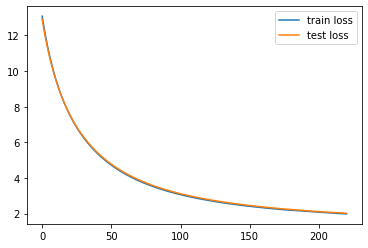

In [31]:
from matplotlib import pyplot as plt
plt.plot(epoches_list, train_losses, label='train loss')
plt.plot(epoches_list, test_losses, label='test loss')
plt.legend(loc="upper right")

In [32]:
np_items = model.item_factors.weight.data.cpu().numpy()
np_users = model.user_factors.weight.data.cpu().numpy()
np_item_bias = model.item_biases.weight.data.cpu().numpy()
np_user_bias = model.user_biases.weight.data.cpu().numpy()

Выберем фильм Pulp Fiction  и с помощью косинусной меры определим 10 наиболее похожих на него.

In [33]:
def cos_dist(a, b):
  return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [34]:
movie_id = movie_dict[296]
similarity_dict = {}
for movie, id in zip(np_items, movie_dict.keys()):
  similarity_dict[id] = cos_dist(movie, np_items[movie_id])

In [40]:
sim_pd = pd.DataFrame(similarity_dict.items(), columns=['movieId', 'similarity'])
sim_pd = sim_pd.merge(movies_pd, on='movieId')
sim_pd.sort_values('similarity', ascending=False)[['similarity', 'title', 'genres']][:10]

,similarity,title,genres
257,1.000000,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
123,0.355252,Apollo 13 (1995),Adventure|Drama|IMAX
2812,0.345988,F/X2 (a.k.a. F/X 2 - The Deadly Art of Illusio...,Action|Crime|Thriller
9429,0.333559,Microwave Massacre (1983),Horror
211,0.319456,Heavenly Creatures (1994),Crime|Drama
794,0.316977,"Lawnmower Man, The (1992)",Action|Horror|Sci-Fi|Thriller
3907,0.315574,Robin and Marian (1976),Adventure|Drama|Romance
134,0.314788,Crimson Tide (1995),Drama|Thriller|War
9334,0.314492,The Infiltrator (2016),Crime|Drama
8083,0.313482,"ABCs of Death, The (2012)",Horror


Выберем произвольного пользователя, получим для него предсказания фильмов, которые он ещё не видел, и выведем топ 30 фильмов по его предсказанной оценке

In [118]:
user_id = 93
np_user = np_users[user_id]
watched_films = np.transpose(data_pd[data_pd['userId'] == user_dict[user_id]][['movieId']].to_numpy())[0]
len(watched_films)

97

In [109]:
np.sort(data_pd[data_pd['userId'] == user_dict[user_id]]['rating'].to_numpy())

array([3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [121]:
pred = np_items.dot(np_users[user_id])
rate_dict = {}
user_bias = np_user_bias[user_id][0]
for pred, item_bias, id in zip(pred, np_item_bias, movie_dict.keys()):
  if not id in watched_films:
    rate_dict[id] = pred + item_bias[0] + user_bias

ratings_pd = pd.DataFrame(rate_dict.items(), columns=['movieId', 'rating'])
ratings_pd = ratings_pd.merge(movies_pd, on='movieId')

ratings_pd.sort_values('rating', ascending=False)[['rating', 'title', 'genres']].set_index(np.arange(1, len(ratings_pd)+1))[:30]

,rating,title,genres
1,2.818322,"Shawshank Redemption, The (1994)",Crime|Drama
2,2.704714,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,2.686809,Forrest Gump (1994),Comedy|Drama|Romance|War
4,2.630515,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
5,2.612348,"Matrix, The (1999)",Action|Sci-Fi|Thriller
6,2.574911,Schindler's List (1993),Drama|War
7,2.552903,Braveheart (1995),Action|Drama|War
8,2.535221,Apollo 13 (1995),Adventure|Drama|IMAX
9,2.529496,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
10,2.504925,Terminator 2: Judgment Day (1991),Action|Sci-Fi
